## Introduction to Atmospheric Radar Course - Practical 4

<img src="NCAS_national_centre_logo_transparent.png" alt="NCAS" style="width: 200px; horizontal-align:left"/>


## Developing radar processing chains
### Part 3 - Applying attenuation corrections

#### Overview
This notebook introduces a methods for correcting weather radar data for attenuation.

The notebook will cover:

1. Attenuation correction using only reflectivity
2. Differential phase shift measurements - filtering and calculating specific differential phase
3. Dual-polarisation attenuation correction


We'll start as usual by importing the python modules we need for this notebook

In [1]:
import pyart
import wradlib
import pyart.graph.cm_colorblind as pycm
import matplotlib.pyplot as plt
import scipy.ndimage as sciim
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Then we can load an example file known to contain attenuating precipitation, as shown in the lecture and set up a ```RadarMapDisplay``` object for that file, allowing us to plot the coastline which will help give an idea of the source of some of the clutter.

In [2]:
radar_file = '/gws/nopw/j04/ncas_radar_vol2/data/ncas-mobile-x-band-radar-1/raine/cfradial/calib_v1/sur/20200723/ncas-mobile-x-band-radar-1_sandwith_20200723-094532_SUR_v1.nc'

radar = pyart.io.read(radar_file)
raddisp = pyart.graph.RadarMapDisplay(radar)

#### Single polarisation attenuation correction using Hitschfeld and Bordan

For this practical we'll apply a gatefilter as shown in the previous practical notebooks, this will allow us to focus on the meteorological echoes in this case. We'll now plot up a multipanel PPI plot of 2 of the variables in the file (see practical 3 for more details on creating multi-panel plots). In addition to reflectivity (dBuZ) we'll also plot differential reflectivity (ZDR) to visually assess the likelihood of attenuation/differential attenuation.

In [3]:
radar.fields['uPhiDPu']['data'][:] = np.ma.masked_array(data=np.where(radar.fields['uPhiDPu']['data']>180,
                                                                  radar.fields['uPhiDPu']['data']-360,
                                                                  radar.fields['uPhiDPu']['data']),
                                                    mask=radar.fields['uPhiDPu']['data'].mask)

gatefilter = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 'ZDRu',
                                                                 'RhoHVu',
                                                                 'uPhiDPu',
                                                                 'dBuZ',
                                                                 min_rhv=0.85)
gatefilter.exclude_below('SQI',0.4)
gatefilter = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter)

/home/users/dufton/software/miniconda3/envs/RadarEnv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


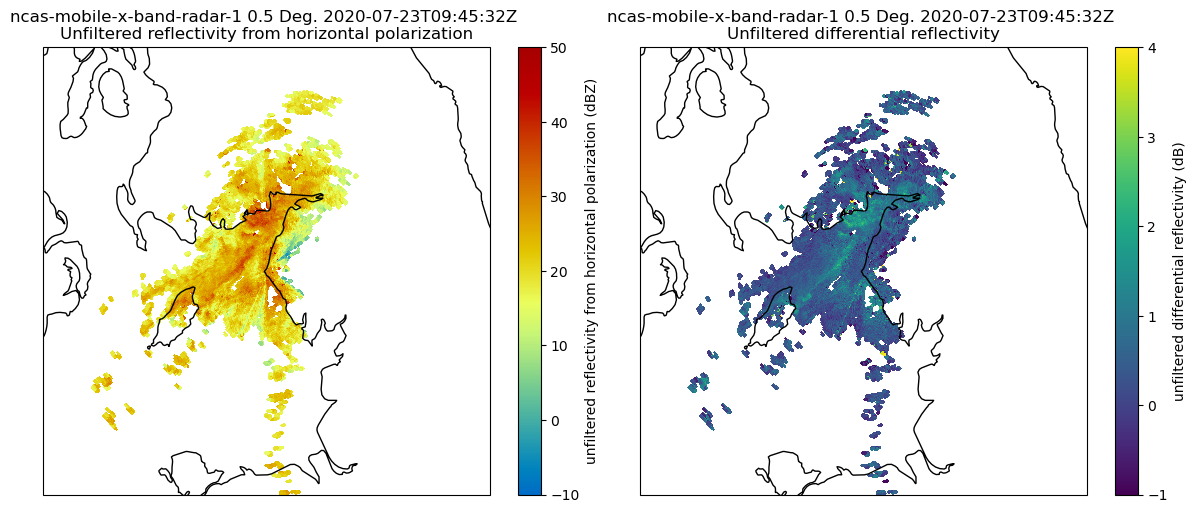

In [4]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=-10,vmax=50,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(122, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax2)

ax2.coastlines(resolution='10m')

plt.tight_layout()

In this example the attenuation is not strikingly obvious, either in the horizontal reflectivity field or the differential reflectivity field. However the region of echoes in excess of 30dBZ to the north of the radar is extensive enough to cause moderate attenuation at X-band frequencies (remember from the lecture that attenuation is frequency dependent, where S-band frequencies have lower attenuation due to the increased wavelength). Starting with the single polarisation approach of Hitschfeld and Bordan (H-B) (1954) we can quantify the total attenuation in this case and apply a simple correction.

Wradlib contains an inbuilt function for applying the iterative H-B technique, [```wradlib.atten.correct_attenuation_hb```](https://docs.wradlib.org/en/latest/generated/wradlib.atten.correct_attenuation_hb.html#wradlib.atten.correct_attenuation_hb). We'll use that here, taking attenuation coefficients from the work of Diederich et al. 2014. These coefficients are frequency dependant (and also vary to a lesser degree as a function of temperature and DSD).


In [5]:
# We'll use the gatefilter to generate a filtered reflectivity field.
# Infilling a nominally small value where the gatefilter excludes data will allow the function to run
# without adding attenuation.
filtered_reflectivity = np.where(gatefilter.gate_included,
                                              radar.fields['dBuZ']['data'],
                                              -9e33)

attenuation_hb = wradlib.atten.correct_attenuation_hb(filtered_reflectivity, 
                                     coefficients={'a':1.62e-4, # 1.62e-4, 1.15e-4 (Values from Diederich et al 2014)
                                                   'b':0.74, # 0.74, 0.78
                                                   'gate_length':0.15})

## We'll add this data to the radar object as a new field. This will allow us to use the plotting functions to 
## visualise the results

radar.add_field('attenuation_HB', {'data': np.ma.masked_where(gatefilter.gate_excluded,
                                                           attenuation_hb),
                                   'standard_name': 'Path integrated attenuation calculated using Wradlib HB method',
                                   'units': 'dB'},
               replace_existing=True)

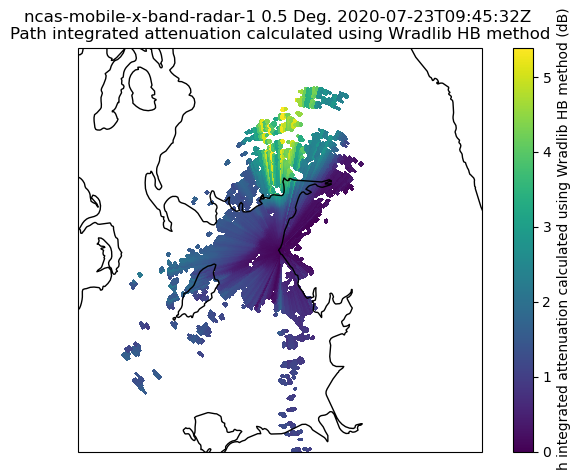

In [6]:
ax1 = plt.subplot(111, projection=proj)
raddisp.plot_ppi_map('attenuation_HB',0, 
                     vmin=0,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax1)

ax1.coastlines(resolution='10m')

plt.tight_layout()

The results from the calculation are the path integrated attenuation (the accumulation of attenuation along the radial). We can use this as a direct correction for the horizontal reflectivity data, using a simple addition. We'll add a new, corrected reflectivity field to the radar object and compare it to the original data with a 2 panel plot.

In [7]:
corrected_reflectivity = radar.fields['dBuZ']['data']+radar.fields['attenuation_HB']['data']
corrected_reflectivity = np.ma.masked_where(gatefilter.gate_excluded,
                                            corrected_reflectivity)

radar.add_field('corrected_reflectivity_HB',
                {'data': corrected_reflectivity,
                 'standard_name': 'Attenuation corrected horizontal reflectivity',
                 'units': 'dBZ'})

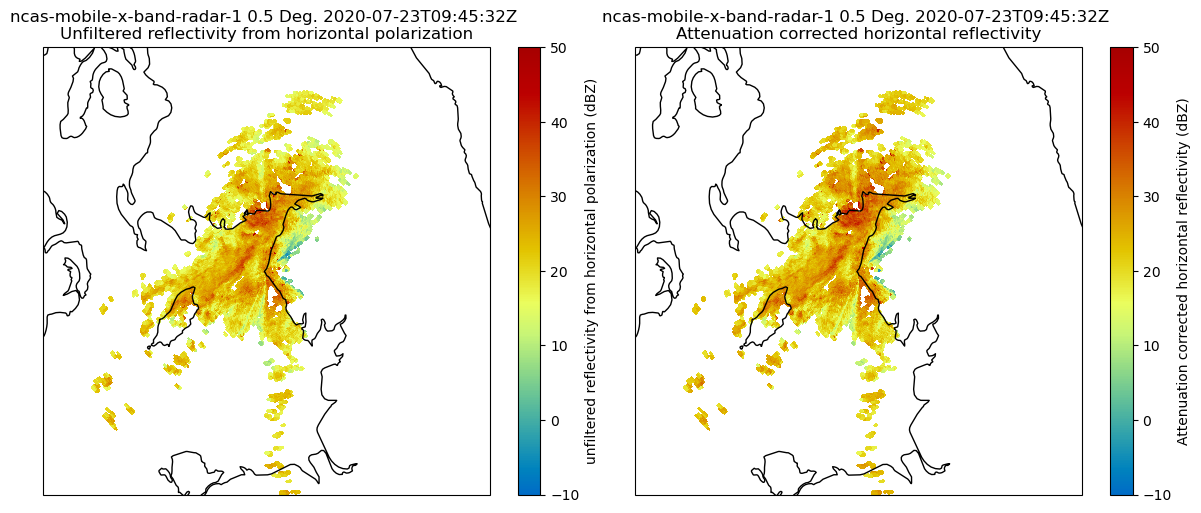

In [8]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=-10,vmax=50,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(122, projection=proj)
raddisp.plot_ppi_map("corrected_reflectivity_HB", 0, 
                 cmap=pycm.HomeyerRainbow,
                     vmin=-10, vmax=50,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax2)

ax2.coastlines(resolution='10m')

plt.tight_layout()

##### Activity
Try modifying the gatefilter - make it less aggressive and consider how that impacts the results of the calculation. What if we don't use a gatefilter at all?

The wradlib example notebook (https://docs.wradlib.org/en/latest/notebooks/attenuation/attenuation.html) covers an example of more advanced single polarisation techniques for attenuation correction at C-band but here we will move on to cover attenuation correction using dual-polarisation. 

#### Moving on to dual polarisation





In [9]:
radar.fields['PhiDP']['data'][:] = np.ma.masked_array(data=np.where(radar.fields['PhiDP']['data']>180,
                                                                  radar.fields['PhiDP']['data']-360,
                                                                  radar.fields['PhiDP']['data']),
                                                    mask=radar.fields['PhiDP']['data'].mask)

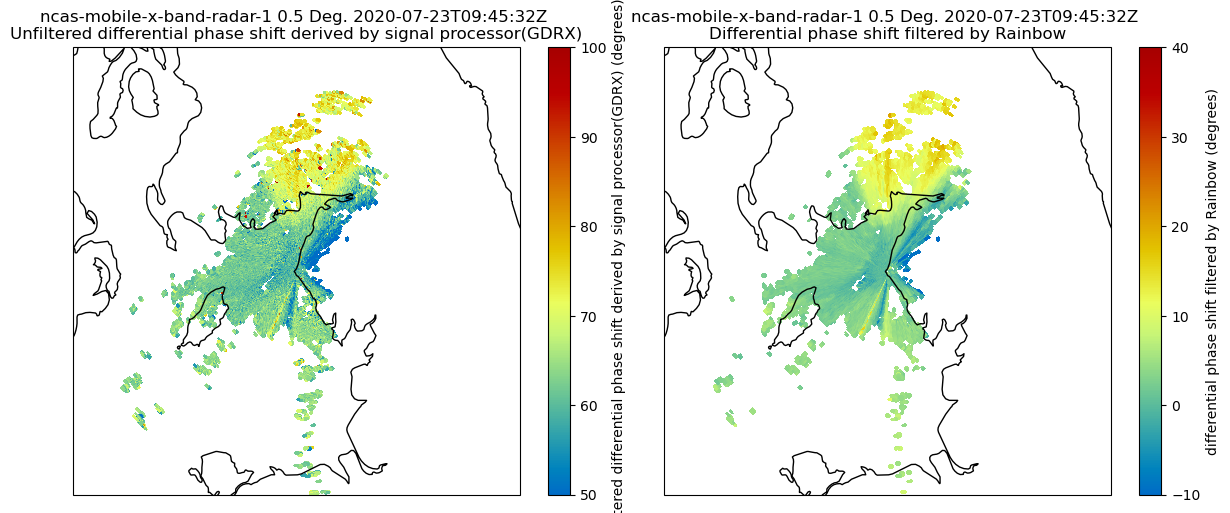

In [12]:
fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121, projection=proj)
raddisp.plot_ppi_map("uPhiDPu", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=50,vmax=100,
                 ax=ax1)
ax1.coastlines(resolution='10m')

ax2 = plt.subplot(122, projection=proj)
raddisp.plot_ppi_map("PhiDP", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=-10,vmax=40,
                 ax=ax2)
ax2.coastlines(resolution='10m')


plt.tight_layout()

In [14]:
radar.azimuth['data'][0]

175.00671

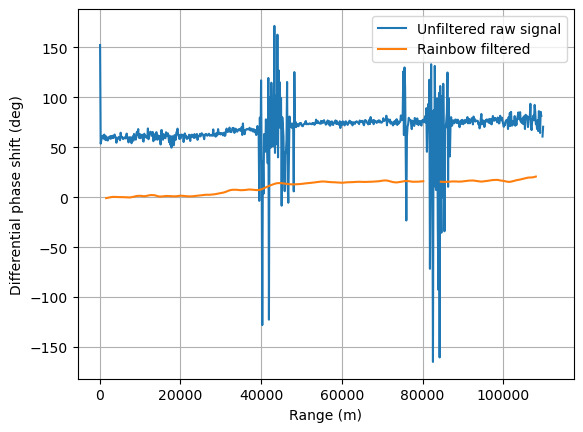

In [22]:
ax1 = plt.subplot(111)

ray_index = 185

plt.plot(radar.range['data'],
         radar.fields['uPhiDPu']['data'][ray_index],label='Unfiltered raw signal')
plt.plot(radar.range['data'],radar.fields['PhiDP']['data'][ray_index], label='Rainbow filtered')
plt.ylabel('Differential phase shift (deg)')
plt.legend()
plt.xlabel('Range (m)')
plt.grid()

The unfiltered raw signal ('uPhiDPu') still contains the system differential phase. First we will estimate this for this example. You could either try to do this visually or use ```np.mean``` or ```np.median``` to estimate the value for the first few valid gates of 'uPhiDPu' data. Once you have a value adjust the ```system_phase``` variable accordingly and create a new plot zoomed towards a phase shift of 0 to 30 degrees.

In [34]:
# Estimate system differential phase here:
system_phase = 59

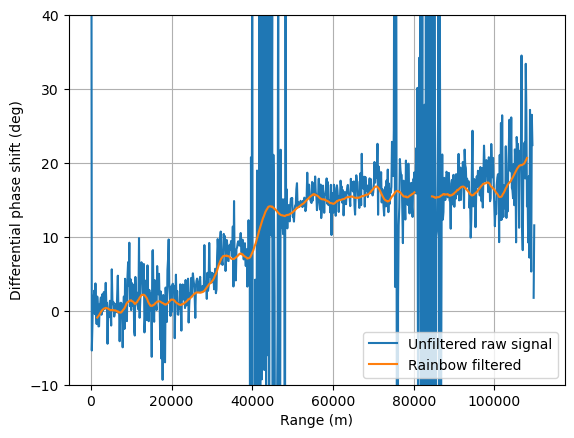

In [35]:
ax1 = plt.subplot(111)

ray_index = 185

plt.plot(radar.range['data'],
         radar.fields['uPhiDPu']['data'][ray_index]-system_phase,
         label='Unfiltered raw signal')
plt.plot(radar.range['data'],radar.fields['PhiDP']['data'][ray_index], label='Rainbow filtered')
plt.ylabel('Differential phase shift (deg)')
plt.legend()
plt.xlabel('Range (m)')
plt.ylim(-10,40)
plt.grid()

In [ ]:
kdp_maesaka = pyart.retrieve.kdp_maesaka(radar,gatefilter=gatefilter3,psidp_field='uPhiDP')

In [ ]:
kdp_vulp = pyart.retrieve.kdp_vulpiani(radar,gatefilter=gatefilter3,psidp_field='uPhiDP',band='X')

In [ ]:
pyart.correct.calculate_attenuation_philinear?